# Overview of Further Probabilistic Models

## Naives Bayes Classification

For a given class $k$, we can use Bayes' theorem 

$$
\begin{align} 
p(C_l~|~x) &= \frac{p(x~|~C_l) ~ p(C_l)}{p(x)}
\end{align} 
$$

with a **naive assumption** that the feature $x = (x_1, \dots, x_n)$ are **conditionally independent**
which allows us to express the contitional propability term $p(x~|~C_l)$ as a product of conditional probabilities of individual features $x_i$.


$$
\begin{align} 
p(C_l~|~x) &= \frac{\prod_{i=1}^n p(x_i~|~C_l) ~ p(C_l)}{p(x)}
\end{align} 
$$

We can now omit $p(x)$, since it does not depend on $l$. Now we can search with a optimization algorithm to find the class which maximises the probability $p(C_l~|~x)$. We call this maximimum a posterior (MAP) decision rule.


$$\hat{y} = \text{argmax}_{l=1,\dots,k} ~\prod_{i=1}^n p(x_i~|~C_l)~p(C_l)  $$


Limits of NBC:
->aspect covariance

So the independece implies zero covariance between two random variables. A non zero covariance leads to Gaussian Mixture Model.


## Gaussian Mixture Model for Clustering

If we generalize the Naive Bayes approach to a non zero covariance matrix, we arrive at Gaussian Mixture Model (GMM) where we assume multivariate Normal distribution 

$$
P(X=x~|~C=j) = \mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

with mean $\mu \in \mathbb{R}^d $ and covariance matrix $\Sigma \in \mathbb{R}^{d\times d }$.

The marginal propability $P(X)$ is a Gaussian Mixture that is weighted sum of mulitvariate Normal distributions

$$
P(X=x) = \sum_{j=1}^k\pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

where $\pi_j:= P(C=j)$ is a mixture coeffiecent for which applies

$$
\sum_{j=1}^J\pi_j=1.
$$
For example a gaussian Mixture would be

$$
P(X=x) = \frac{1}{2}\mathcal{N_2}(\mu_0,\Sigma_0+\frac{1}{2}\mathcal{N_2}(\mu_1,\Sigma_1)
$$

with 

$$
\pi_{0,1}=0.5,\quad \mu_0=[0,0],\quad \mu_1=[1.5,-1.5].\quad \Sigma_{0,1}=
\left[\begin{array}{rr} 
1 & 0.95  \\ 
0.95 & 1  \\ 
\end{array}\right]
$$


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from matplotlib import cm

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_mutual_info_score

plt.style.use('default')
sns.set_style("whitegrid")

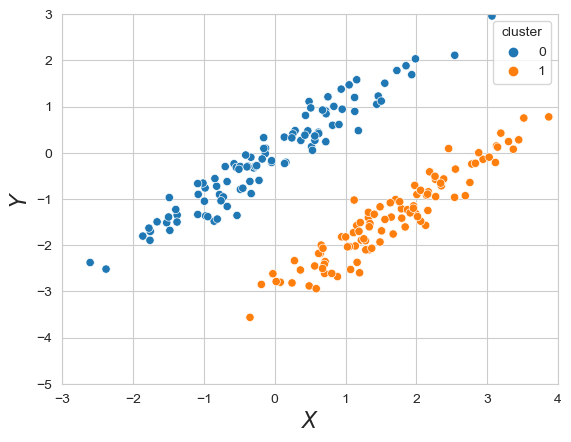

In [4]:
mean_1=[0,0]
cov_1=[[1, 0.95],[0.95, 1]]
x = multivariate_normal.rvs(mean=mean_1, cov=cov_1, size=100)
data_cigars_1 = pd.DataFrame( {'x': x[:,0], 'y': x[:,1], 'cluster': [0]*100 })

mean_2=[1.5,-1.5]
cov_2=[[1, 0.95],[0.95, 1]]
x = multivariate_normal.rvs(mean=mean_2, cov=cov_2, size=100)
data_cigars_2 = pd.DataFrame( {'x': x[:,0], 'y': x[:,1], 'cluster': [1]*100 })

data_cigars = data_cigars_1.append(data_cigars_2)

sns.scatterplot(x='x', y='y', data=data_cigars, hue='cluster')
plt.xlim(-3, 4)
plt.ylim(-5, 3)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16);

We now gnerated two clusters which are close to each other but can clearly saperated. A K-means algorithm would not cluster these in proper way. But as we saw above, we already defined a Gaussian Mixture which would obviously fit this data perferctly.

In [5]:
def gaussian_mixture_proba(pos_for_pdf, mu, cov, pi):
    s = 0
    k = len(mu)
    for j in range(k):
        s += pi[j] * multivariate_normal.pdf(pos_for_pdf, mu[j], cov[j]) 
    return s

In [6]:
mu = np.array([mean_1, mean_2])
cov = np.array([np.array(cov_1), np.array(cov_2)])
pi = np.array([0.5, 0.5])

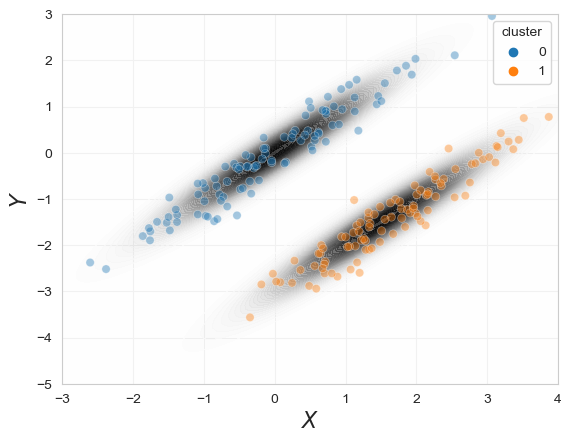

In [7]:
fig, ax = plt.subplots(1,1)
x = np.linspace(-3,4,100)
y = np.linspace(-5,3,100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
ax.contourf(X, Y, gaussian_mixture_proba(pos, mu=mu, cov=cov, pi=pi), 50, cmap=cm.Greys, alpha=0.75)
sns.scatterplot(x='x', y='y', data=data_cigars, hue='cluster', alpha=0.4)
plt.xlim(-3, 4)
plt.ylim(-5, 3)
plt.ylabel(r'$Y$', fontsize=16)
plt.xlabel(r'$X$', fontsize=16);

As an esay example we had assumed that we already know the GMM parameters to show that the model can fit the data. The big problem is that we need to find these parameters $(\pi_j,\mu_j\Sigma_j)_{j=1,...,k}$ for the gaussian mixture which fits the data best. We will begin with the inference of parameters in GMM

For data $D={x_i:i=1,...,n}$ and parameters $\Theta$ model likelihood is given by

$$
\mathcal{L}(\Theta~|~D)= \prod_{i=1}^nP(X=x_i)=\prod_{i=1}^n\sum_{j=1}^k \pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

and log-likelihood is given as

$$
\log \mathcal{L}(\Theta~|~D)=\sum_{i=1}^n\log\sum_{j=1}^k \pi_j\mathcal{N_p}(x;\mu_j,\Sigma_j)
$$

The question now is how we can infer the parameters of a GMM that best explain the data? Our first idea is to compute the likelihood of the model parameters, given a data set $D$. To maximise this likelihood, we can try to simplify the likelihood expression using our standard trick, that is we take the logarithm and maximise the log-likelihood function instead.

Unfortunately, in the GMM this is not as simple as in our previous applications of maximum-likelihood estimation(MLE). We are left  with a logarithm of a sum of Gaussians, for which we cannot compute the derivative in a straight-forward way.

**Expectation-Maximisation (EM)**

Let us assume we knew the "correct" cluster $C(i)$ for each $x_i\in D$. We can write the likelihood of model parameters $\Theta$ based on joint distribution

$$
\mathcal{L}(\Theta~|~D)= \prod_{i=1}^nP(X=x_i,C=C(i)~|~\Theta).
$$

The log-likelihood of the model is

$$
\log \mathcal{L}(\Theta~|~D)= \sum_{i=1}^n\log P(X=x_i,C=C(i)~|~\Theta).
$$

For a guess of parameters $\Theta^{(t)} = (\pi_j,\mu_j\Sigma_j)_{j=1,...,k}$ the expected log-likelihood can be calculated as

$$
E[\log\mathcal{L}(\Theta~|~D)]= \sum_{i=1}^n \sum_{j=1}^k P(C=j~|~X=x_i,\Theta^{(t)})\log P(X=x_i,C=j~|~\Theta).
$$




To find the optimal parameters of the $k d$-dimensional multivariate Normal distributions that maximise the likelihood, we can apply a general and powerful iterative approach, the so-called expectation-maximisation (EM) algorithm. It is based on the idea that, rather than maximising the model likelihood based on the marginal probability $P(X)$, we can instead use an  estimate for the conditional probability $P(C~|~X)$ to compute the expected log-likelihood based on the joint distribution $P(X, C)$.

To better understand this, let us assume we knew the cluster $C(i)$ for each observation $x_i \in D$. For each we could then calculate the likelihood and log-likelihood function of our model based on the joint distribution $P(X, C)$. Unfortunately, we lack the information to which clusters the data points belong. However, we can capture this lack of information based on the conditional probability $P(C|X)$, which we can compute for any guess of parameters $\Theta^{(t)}$.

For $j=1,...,k$ we use guessed parameters $\Theta^{(t)}$ to calculate

$$
P(C=j~|~X=x_i,\Theta^{(t)})= \frac{\mathcal{N_d}(x;\mu_j,\Sigma_j)\pi_j}{\sum_{j=1}^k\mathcal{N_d}(x;\mu_j,\Sigma_j)}:=\gamma_{ij}.
$$ 

Update $\Theta^{(t)}\rightarrow \Theta^{(t+1)}$ such that $\gamma_{ij}$ and thus $E[\log\mathcal{L}(\Theta~|~D)]$ is maximal.
With $N_j:=\sum_{i=1}^n\gamma_{ij}$ expactation-maximising parameters are

$$
\pi_j = \frac{N_j}{n}, \quad \mu_j = \frac{1}{N_j}\sum_{i=1}^n\gamma_{ij}x_i, \quad \Sigma_j=\frac{1}{N_j}\sum_{i=1}^n\gamma_{ij}(x_i -\mu_j)(x_i-\mu_j)^T.
$$

The expactation-maximisation agorithm iteratively updates  $\Theta^{(t)}\rightarrow \Theta^{(t+1)}$ to find maximum-likehood parameters

The trick is now to compute $P(C~|~X)$ based on our current guess of $\Theta^{(t)}$ and then update the parameters such that $P(C~|~X)$ and the expected log-likelihood is maximised. Those maximum parameters can actually be determined by taking the
derivative of the conditional probability (the constraint $\sum_{j=1}\pi_j=1$ requires quadratic programming to find $\pi_j$).

We can now use the updated parameters to get a better estimate for the conditional probability, so we can simply repeat the procedure. In each step, we first compute the expectation for the model likelihood and then find the parameters that maximise this expectation, which is why the algorithm is called expectation-maximisation.

This yields an iterative algorithm, which starts from an initial guess of the model parameters and then, step-by-step, updates the model parameters to iteratively increase the model likelihood until we reach a maximum.

Text(0, 0.5, '$Y$')

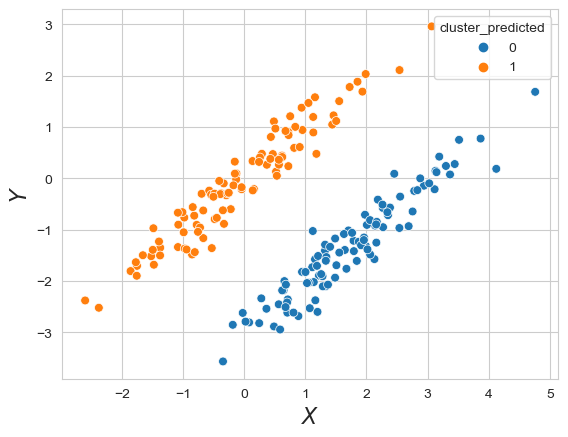

In [19]:
model = GaussianMixture(n_components=2, covariance_type='full')
model.fit(data_cigars[['x', 'y']])
data_cigars['cluster_predicted'] = model.predict(data_cigars[['x', 'y']])
plt.clf()
sns.scatterplot(x='x', y='y', s=40, hue='cluster_predicted', data=data_cigars)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16)

To visualize these Expectiation Maximisation algorithm we show "EM clustering of Old Faithful eruption data" from Wikipedia.

<a href="https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm"> <left><img src="https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif"></left></a>

However this approach is not limited to gaussian. A mixture model could persist of any distributon.

## Bayesian Neural Networks

"A BNN is defined slightly differently across the literature,but a common definition is that a BNN is a stochastic artificial neural network trained using Bayesian inference." {cite}```Jospin2021```
The goal of a general artifial neural network(ANN) is to represent any funtion $y = g(x)$. The simplest function, a linear mapping, can be build by one neuron which have exactly one weight to repreduce the slope and a bias to represent the offset of the linear mapping. For a more complex or general approach we concat and stack several of these neuron together to achieve more complex functions. We also add in each neuron an activation function which can turn the neuron on or (partly) off. As example see the picture below.

<a href="https://en.wikipedia.org/wiki/Artificial_neural_network"> <left><img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Artificial_neural_network.svg"></left></a>

A deep neural network is defined with input layer, a output layer and at least one hidden layer in between as seen in picture above. Here we want to finde the optimal parameters $\theta  = (W,b)$ where $W$ is the weights and $b$ are the biases of the network. The approach here is to approximate a minimal cost point estimate of the network parameters $\theta$, a single value for each parameter, using the back-propagation algorithm.

**Stochastic neural networks** are a type of ANNs built by introducing stochastic components into the network. This can be done by given the network a stochastic activation or stochastics weights. This is graphically shown underneath from {cite}```Jospin2021```.

<a href="https://arxiv.org/pdf/2007.06823.pdf"> <left><img src="NNintro.PNG" width="800px" alt="NN,SNN"/></left></a>

On the left we see point estimate. In the middle are stochastic activations and on the right stochastics weights.The main goal of using a stochastic neural network architecture is to get a better idea of the uncertainty associated with the underlying processes. This is achieved by comparing the predictions of several sampled model parameterizations $\theta$. When the different models match, the uncertainty is low. If they do not match, then the uncertainty is high. This process can be summarized as follows:

$$
\theta \sim p(\theta) \\
y=g_0(x)+ \epsilon
$$

where $\epsilon$ is a random noise. And a **BNN** is a stochastical network which uses Baysian inference as training.To design an BNN we make a choice about the network architecture. Then we need to choose a stochstic model which means a prior distribution over possible model parametrizations $p(\theta)$ and a prior confindence in the predictive power of the model $P(y|x,\theta)$. With the assumption of independence between the input variables $D=(x,y)$ and the model parameters $\theta$ and the use of bayes theorem the posterior can be written as

$$
p(\theta|x,y)= \frac{p(y|x,\theta)p(\theta)}{\int_{\theta}p(y|x,\theta')p(\theta')d\theta'}.
$$

To compute this, there are two broad approaches available: Markov Monto Carlo Chain (MCMC) and Variational Inference. For predictions we are interested in the marginal probility distribution $p(y|x,D)$ which quantifies the uncertainty of the model prediction. Usually a model averaging is done for prediction:

$$
\hat y = \frac{1}{|\Theta|}\sum_{\theta_i \in \Theta}g_{\theta_i}(x)
$$
where $\Theta$ is a collection of samples from $p(\theta|D)$ and $\hat y$ is the prediction.

We will now take a look on a implemtation example for BNN in `tensorflow` with the "red wine quality" dataset.

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [10]:
def get_train_and_test_splits(train_size, batch_size=1):
    # We prefetch with a buffer the same size as the dataset because th dataset
    # is very small and fits into memory.
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

In [11]:
hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset,verbose=0)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [12]:
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

Experiment 1: standard neural network
We create a standard deterministic neural network model as a baseline.

In [13]:
def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

num_epochs = 100
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

Start training the model...
Model training finished.
Train RMSE: 0.75
Evaluating model performance...
Test RMSE: 0.737


In [14]:
sample = 10
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = baseline_model(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

Predicted: 6.4 - Actual: 7.0
Predicted: 6.6 - Actual: 8.0
Predicted: 5.9 - Actual: 5.0
Predicted: 5.4 - Actual: 5.0
Predicted: 5.9 - Actual: 5.0
Predicted: 5.3 - Actual: 5.0
Predicted: 5.8 - Actual: 6.0
Predicted: 5.6 - Actual: 5.0
Predicted: 5.0 - Actual: 5.0
Predicted: 5.3 - Actual: 5.0


Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach for modeling neural networks is to capture the epistemic uncertainty, which is uncertainty about the model fitness, due to limited training data.

The idea is that, instead of learning specific weight (and bias) values in the neural network, the Bayesian approach learns weight distributions - from which we can sample to produce an output for a given input - to encode weight uncertainty.

Thus, we need to define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions.

In [15]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(      #here we used standard dense before!!!!
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

bnn_model_small = create_bnn_model(train_sample_size)
run_experiment(bnn_model_small, mse_loss, small_train_dataset, test_dataset)

Start training the model...
Model training finished.
Train RMSE: 0.782
Evaluating model performance...
Test RMSE: 0.793


In [16]:
def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )


compute_predictions(bnn_model_small)

Predictions mean: 6.17, min: 5.76, max: 6.37, range: 0.62 - Actual: 7.0
Predictions mean: 6.31, min: 6.0, max: 6.45, range: 0.44 - Actual: 8.0
Predictions mean: 5.97, min: 5.1, max: 6.3, range: 1.21 - Actual: 5.0
Predictions mean: 5.29, min: 4.09, max: 5.99, range: 1.91 - Actual: 5.0
Predictions mean: 6.13, min: 5.5, max: 6.4, range: 0.9 - Actual: 5.0
Predictions mean: 5.3, min: 4.33, max: 6.02, range: 1.7 - Actual: 5.0
Predictions mean: 6.02, min: 5.28, max: 6.31, range: 1.03 - Actual: 6.0
Predictions mean: 5.66, min: 4.72, max: 6.04, range: 1.32 - Actual: 5.0
Predictions mean: 5.07, min: 4.01, max: 5.86, range: 1.84 - Actual: 5.0
Predictions mean: 5.26, min: 4.31, max: 5.88, range: 1.57 - Actual: 5.0


In [17]:
#Full model
num_epochs = 500
bnn_model_full = create_bnn_model(train_size)
run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)

compute_predictions(bnn_model_full)

Start training the model...
Model training finished.
Train RMSE: 0.764
Evaluating model performance...
Test RMSE: 0.762
Predictions mean: 6.35, min: 6.01, max: 6.49, range: 0.48 - Actual: 7.0
Predictions mean: 6.58, min: 6.35, max: 6.65, range: 0.3 - Actual: 8.0
Predictions mean: 6.01, min: 5.66, max: 6.33, range: 0.67 - Actual: 5.0
Predictions mean: 5.38, min: 5.0, max: 5.85, range: 0.84 - Actual: 5.0
Predictions mean: 6.25, min: 5.66, max: 6.47, range: 0.81 - Actual: 5.0
Predictions mean: 5.21, min: 4.89, max: 5.71, range: 0.82 - Actual: 5.0
Predictions mean: 5.91, min: 5.53, max: 6.19, range: 0.66 - Actual: 6.0
Predictions mean: 5.53, min: 5.22, max: 6.02, range: 0.8 - Actual: 5.0
Predictions mean: 5.12, min: 4.81, max: 5.55, range: 0.74 - Actual: 5.0
Predictions mean: 5.25, min: 4.88, max: 5.77, range: 0.89 - Actual: 5.0


## Variational Autoencoder (VAE)

The main idea for a general autoencoder is dimensionality reduction but however it is also used for learning generative models of data. The idea is, we build a Neural Network with a input layer for our data, smaller hidden layers than our input layer and an output layer with the same dimension of neuron as the input layer. The NN will learn how to encode(reduce) the data to a given hidden layer in the middle of the network and will also learn how to decode the reduced data to the original data.

The loss of this function is called reconstructon error and is often a mean squared error.

For visual reference we will show the picture below. There you can see a autoencoder architecture in general. 

<a href="https://en.wikipedia.org/wiki/Autoencoder"> <left><img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png"></left></a>

Variational autoencoders are meant to encode (compress) the input data into a constrained multivariate latent distribution to decode (reconstruct) it as accurately as possible. So instead of just a dimensional reduction we used in the middle hidden layer of a general autoencoder we use a middle layer with mean and standard deviation. Underneath is a architecture of a VAE which a distribution in the middle layer.

<a href="https://en.wikipedia.org/wiki/Variational_autoencoder"> <left><img src="https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png"></left></a>

Here we use a slightly different loss. We will use the a mean of the evidence lower bound (ELBO) and a reconstruction error e.g.:MSE.
This results in a tighter ordered latent space with less space in between the initial samples. This will allow us to generate new samples 

The next picture shows the latent space of the mnist dataset done by Irhum Shafkat. There is a lot of space in between the different classes and we get issues if we want to sample in areas which we have not data from the decoder. A better picture is shown in this post for VAE.
<a href="https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf"> <left><img src="https://miro.medium.com/max/500/1*-i8cp3ry4XS-05OWPAJLPg.png"></left></a>


```{bibliography}
:filter: docname in docnames
:style: plain
```